In [1]:
import cv2
import os
import shutil

video_path = "C:/Users/User/Downloads/Media7.mp4"

frames_output_folder = "C:/Users/User/Downloads/lframes/color"
grayscale_output_folder = "C:/Users/User/Downloads/lframes/gray"

def clear_directory(directory):
    if os.path.exists(directory):
        print(f"Clearing directory: {directory}")
        
        shutil.rmtree(directory)
    
    os.makedirs(directory, exist_ok=True)

clear_directory(frames_output_folder)
clear_directory(grayscale_output_folder)

use_cuda = cv2.cuda.getCudaEnabledDeviceCount() > 0

def process_frame(frame):
    """Converts frame to grayscale using CUDA if available"""
    if use_cuda:
        gpu_frame = cv2.cuda_GpuMat()
        gpu_frame.upload(frame)
        gray_gpu = cv2.cuda.cvtColor(gpu_frame, cv2.COLOR_BGR2GRAY)
        return gray_gpu.download()
    else:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

def process_video(video_path):
    """Extracts frames from a video and saves them in color and grayscale"""
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    try:
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        saved_count = 0
        frame_skip = 3  
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_skip == 0:
                frame_filename = os.path.join(frames_output_folder, f"{video_name}_frame_{saved_count:04d}.jpg")
                cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_JPEG_QUALITY, 90])
                gray_image = process_frame(frame)
                gray_filename = os.path.join(grayscale_output_folder, f"{video_name}_gray_{saved_count:04d}.jpg")
                cv2.imwrite(gray_filename, gray_image, [cv2.IMWRITE_JPEG_QUALITY, 90])
                saved_count += 1
            frame_count += 1
        cap.release()
        print(f"Processed: {video_name} - Saved {saved_count} frames")
    except Exception as e:
        print(f"Error processing {video_name}: {e}")

process_video(video_path)

Clearing directory: C:/Users/User/Downloads/lframes/color
Clearing directory: C:/Users/User/Downloads/lframes/gray
Processed: Media7 - Saved 85 frames


Enter frame numbers to process (comma-separated, e.g., '0,5,10,15'): 5,45,70
Clearing directory: C:/Users/User/Downloads/lframes/Shadow
Detecting pattern from sample file: Media7_gray_0000.jpg
Detected video name: Media7
Detected file pattern: Media7_gray_{:04d}.jpg
Processing frame 5: C:/Users/User/Downloads/lframes/gray\Media7_gray_0005.jpg


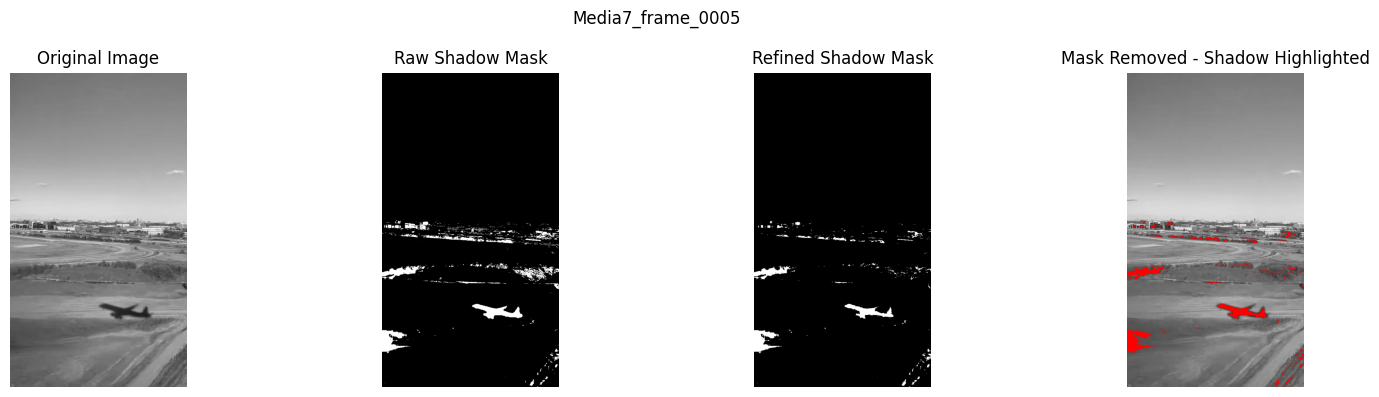

Successfully processed frame 5
Processing frame 45: C:/Users/User/Downloads/lframes/gray\Media7_gray_0045.jpg


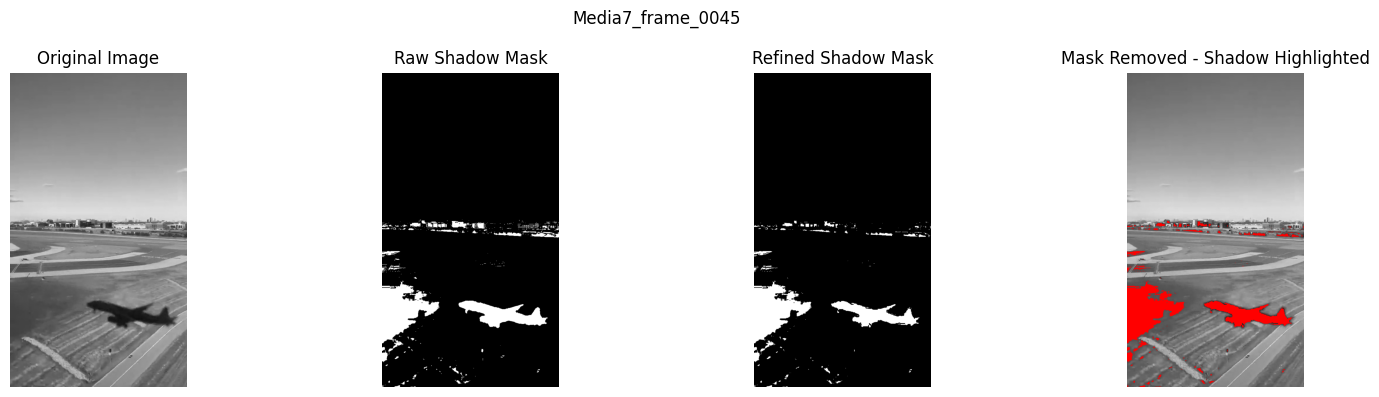

Successfully processed frame 45
Processing frame 70: C:/Users/User/Downloads/lframes/gray\Media7_gray_0070.jpg


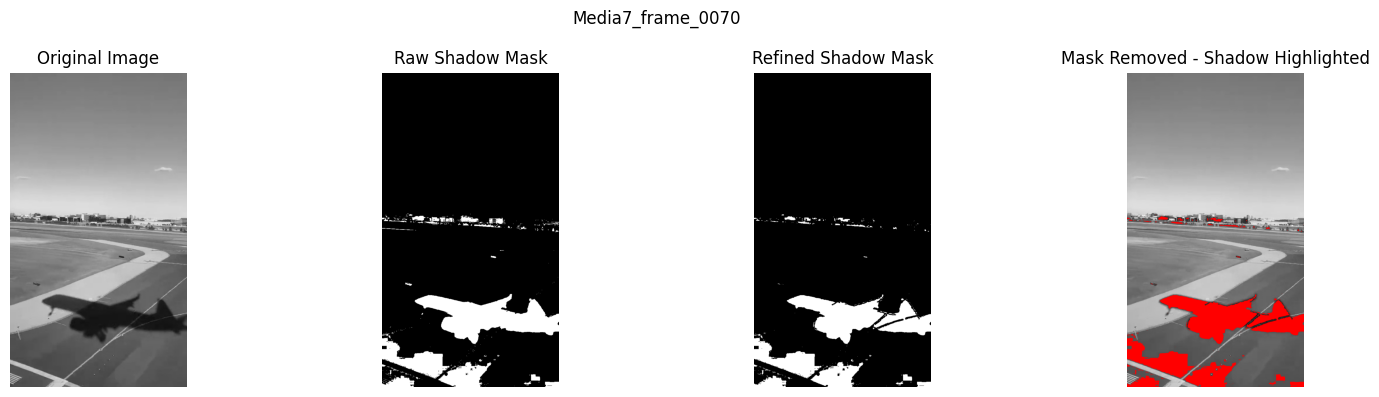

Successfully processed frame 70
Shadow detection completed for 3 frames.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import re

def clear_directory(directory):
    """Clear a directory and recreate it"""
    if os.path.exists(directory):
        print(f"Clearing directory: {directory}")
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

def load_image(image_path):
    """ Load image in grayscale. """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found: {image_path}")
    return image

def detect_shadows(image):
    """ Detects shadows while ignoring dark object parts. """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    _, shadow_mask = cv2.threshold(v_channel, 80, 255, cv2.THRESH_BINARY_INV)
    
    edges = cv2.Canny(image, 50, 150)
    edges_dilated = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
    refined_shadow_mask = cv2.bitwise_and(shadow_mask, cv2.bitwise_not(edges_dilated))
    
    return shadow_mask, refined_shadow_mask

def remove_object_mask(image, refined_shadow_mask):
    """ Removes object mask while keeping the shadow highlighted. """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, object_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    object_mask = cv2.dilate(object_mask, np.ones((5,5), np.uint8), iterations=2)
    shadow_only = cv2.bitwise_and(refined_shadow_mask, cv2.bitwise_not(object_mask))
    highlighted_image = image.copy()
    highlighted_image[shadow_only > 0] = [0, 0, 255]
    return shadow_only, highlighted_image

def save_results(output_folder, image_name, shadow_mask, refined_mask, shadow_only, highlighted_image):
    """ Save the processed images. """
    os.makedirs(output_folder, exist_ok=True)
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_shadow_mask.png"), shadow_mask)
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_refined_mask.png"), refined_mask)
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_shadow_only.png"), shadow_only)
    cv2.imwrite(os.path.join(output_folder, f"{image_name}_highlighted.png"), highlighted_image)

def visualize_results(original, shadow_mask, refined_mask, highlighted_image, image_name, output_folder):
    """ Display images side by side for comparison. """
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(shadow_mask, cmap='gray')
    plt.title("Raw Shadow Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(refined_mask, cmap='gray')
    plt.title("Refined Shadow Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    plt.title("Mask Removed - Shadow Highlighted")
    plt.axis("off")
    
    plt.suptitle(image_name)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{image_name}_visualization.png"))
    plt.show()

def detect_video_name_and_pattern(input_folder):
    """
    Detect the video name and filename pattern from existing frames in the folder.
    Returns the video name and a regex pattern to match frame numbers.
    """
    files = [f for f in os.listdir(input_folder) if f.lower().endswith('.jpg')]
    
    if not files:
        raise ValueError(f"No frame images found in {input_folder}")
    
    sample_file = files[0]
    print(f"Detecting pattern from sample file: {sample_file}")
    
    match = re.match(r'(.+?)_(gray|frame)_(\d+)\.jpg', sample_file)
    
    if match:
        video_name = match.group(1)
        frame_type = match.group(2)  
        pattern = f"{video_name}_{frame_type}_{{:04d}}.jpg"
        print(f"Detected video name: {video_name}")
        print(f"Detected file pattern: {pattern}")
        return video_name, pattern
    else:
        
        print("Could not determine exact pattern, using default naming")
        return "unknown", "frame_{:04d}.jpg"

def process_selected_frames(input_folder, output_folder, frame_numbers):
    """ Process only the selected frame numbers. """
    clear_directory(output_folder)
    
    
    try:
        video_name, file_pattern = detect_video_name_and_pattern(input_folder)
    except ValueError as e:
        print(f"Error: {e}")
        return
    
    
    for frame_num in frame_numbers:
        
        frame_filename = file_pattern.format(frame_num)
        frame_path = os.path.join(input_folder, frame_filename)
        
        if not os.path.exists(frame_path):
            print(f"Warning: Frame {frame_num} ({frame_path}) not found, skipping.")
            continue
            
        try:
            print(f"Processing frame {frame_num}: {frame_path}")
            original_image = load_image(frame_path)
            shadow_mask, refined_shadow_mask = detect_shadows(original_image)
            shadow_only, highlighted_image = remove_object_mask(original_image, refined_shadow_mask)
            
            base_name = f"{video_name}_frame_{frame_num:04d}"
            save_results(output_folder, base_name, shadow_mask, refined_shadow_mask, shadow_only, highlighted_image)
            visualize_results(original_image, shadow_mask, refined_shadow_mask, highlighted_image, base_name, output_folder)
            
            print(f"Successfully processed frame {frame_num}")
        except Exception as e:
            print(f"Error processing frame {frame_num}: {e}")

gray_frames_folder = 'C:/Users/User/Downloads/lframes/gray'  
shadow_output_folder = 'C:/Users/User/Downloads/lframes/Shadow'  


def get_frame_numbers():
    while True:
        try:
            input_str = input("Enter frame numbers to process (comma-separated, e.g., '0,5,10,15'): ")
            frame_numbers = [int(num.strip()) for num in input_str.split(',')]
            return frame_numbers
        except ValueError:
            print("Invalid input. Please enter comma-separated numbers.")

if __name__ == "__main__":
    selected_frames = get_frame_numbers()
    
    process_selected_frames(gray_frames_folder, shadow_output_folder, selected_frames)
    
    print(f"Shadow detection completed for {len(selected_frames)} frames.")

Found 3 highlighted frames to analyze
Shadow Classification: OBJECT
Object Classification: SHADOW
Shadow Angle Changes: [-5.9156275945269226, -13.31530807984441, 8.340263392689586]
Object Angle Changes: [0.8066152467512054, -3.2439289279748884, -7.279555876583382]
Shadow Rate of Change: [-7.39968049 21.65557147]
Object Rate of Change: [-4.05054417 -4.03562695]
Shadow Dynamic Threshold: 21.79143896838861
Object Dynamic Threshold: 0.6

--- FINAL RESULT ---
Analysis inconclusive, more frames needed


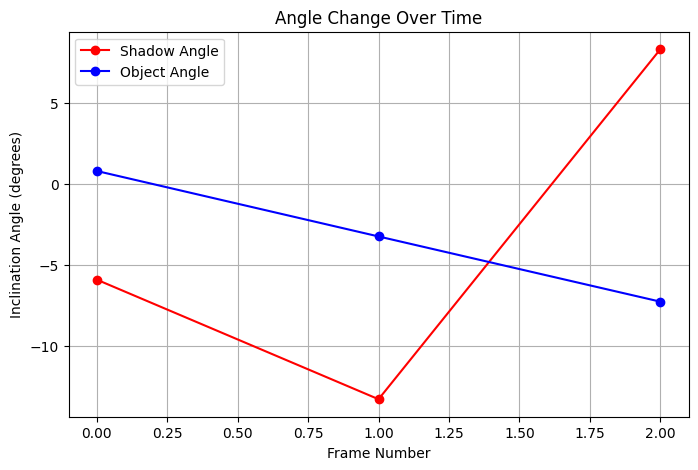

In [3]:
import cv2
import numpy as np
import re
import os
import matplotlib.pyplot as plt

input_folder = 'C:/Users/User/Downloads/lframes/Shadow'  
video_name = None  

def detect_video_name_and_pattern(input_folder):
    """
    Detect the video name from existing frames in the folder.
    """
    files = [f for f in os.listdir(input_folder) if f.lower().endswith('_highlighted.png')]
    
    if not files:
        raise ValueError(f"No shadow-highlighted images found in {input_folder}")
    
    sample_file = files[0]
    
    match = re.match(r'(.+?)_frame_\d+_highlighted\.png', sample_file)
    
    if match:
        video_name = match.group(1)
        return video_name
    else:
        return "unknown"

def extract_shadow_mask(image):
    """Extracts the mask for red-highlighted shadows."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower1 = np.array([0, 120, 70])
    upper1 = np.array([10, 255, 255])
    lower2 = np.array([170, 120, 70])
    upper2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)
    
    return mask1 + mask2  

def extract_object_edges(image, shadow_mask):
    """Extracts object edges while ignoring the red shadow."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[shadow_mask > 0] = 0  

    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    return edges

def calculate_inclination(edges):
    """Finds the inclination angle using Probabilistic Hough Transform."""
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)

    if lines is not None:
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))  
            angles.append(angle)
        
        angles = np.array(angles)
        filtered_angles = angles[(angles > -80) & (angles < 80)]  

        if len(filtered_angles) > 0:
            return np.mean(filtered_angles) 

    return None

def get_all_highlighted_images(input_folder):
    """Get all highlighted images from the folder, sorted by frame number."""
    highlighted_files = [f for f in os.listdir(input_folder) if f.lower().endswith('_highlighted.png')]
    
    if not highlighted_files:
        raise ValueError(f"No highlighted images found in {input_folder}")
    
    def extract_frame_num(filename):
        match = re.search(r'_frame_(\d+)_highlighted\.png', filename)
        if match:
            return int(match.group(1))
        return 0
    
    highlighted_files.sort(key=extract_frame_num)
    image_paths = [os.path.join(input_folder, f) for f in highlighted_files]
    
    print(f"Found {len(image_paths)} highlighted frames to analyze")
    return image_paths

def process_images(image_paths):
    """Processes images, extracts inclination angles, and computes rate of change."""
    shadow_angles, object_angles = [], []
    frame_info = []

    for path in image_paths:
        image = cv2.imread(path)
        shadow_mask = extract_shadow_mask(image)

        shadow_angle = calculate_inclination(shadow_mask)
        object_edges = extract_object_edges(image, shadow_mask)
        object_angle = calculate_inclination(object_edges)
        
        frame_name = os.path.basename(path).split('_highlighted.png')[0]
        
        frame_data = {
            "frame": frame_name,
            "shadow_angle": shadow_angle,
            "object_angle": object_angle
        }
        frame_info.append(frame_data)

        if shadow_angle is not None:
            shadow_angles.append(shadow_angle)
        if object_angle is not None:
            object_angles.append(object_angle)

   


    
    shadow_rate = np.diff(shadow_angles)
    object_rate = np.diff(object_angles)

    shadow_threshold = np.std(shadow_rate) * 1.5  # More tolerance for shadow changes
    object_threshold = max(np.std(object_rate), 0.5) * 1.2  # Ensure reasonable threshold

    # Classification Logic
    if np.any(np.abs(shadow_rate) > shadow_threshold):
        shadow_class = "SHADOW"
    else:
        shadow_class = "OBJECT"

    if np.all(np.abs(object_rate) < object_threshold):
        object_class = "OBJECT"
    else:
        object_class = "SHADOW"

    # Additional Check: If both are SHADOW, compare absolute angles
    if shadow_class == "SHADOW" and object_class == "SHADOW":
        angle_diff = np.mean(np.abs(np.array(shadow_angles) - np.array(object_angles)))
        if angle_diff > 10:  # If object angles are much different from shadow
            object_class = "OBJECT"

    print(f"Shadow Classification: {shadow_class}")
    print(f"Object Classification: {object_class}")
    print(f"Shadow Angle Changes: {shadow_angles}")
    print(f"Object Angle Changes: {object_angles}")
    print(f"Shadow Rate of Change: {shadow_rate}")
    print(f"Object Rate of Change: {object_rate}")
    print(f"Shadow Dynamic Threshold: {shadow_threshold}")
    print(f"Object Dynamic Threshold: {object_threshold}")
    if shadow_class == "SHADOW" and object_class == "SHADOW":
        print(f"Angle Difference Check: {angle_diff}")

    # Final Result
    print("\n--- FINAL RESULT ---")
    if shadow_class == "SHADOW" and object_class == "OBJECT":
        print("The red highlighted areas are SHADOWS")
    elif shadow_class == "OBJECT" and object_class == "OBJECT":
        print("The red highlighted areas are part of the OBJECT")
    else:
        print("Analysis inconclusive, more frames needed")
        
    return shadow_angles, object_angles
        

def visualize_shadow_object_angles(shadow_angles, object_angles):
    """
    Visualizes inclination angles over time for shadow and object regions.
    """
    if not shadow_angles or not object_angles:
        print("Insufficient data for visualization.")
        return

    frames = list(range(len(shadow_angles)))

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(shadow_angles)), shadow_angles, 'ro-', label="Shadow Angle")
    plt.plot(range(len(object_angles)), object_angles, 'bo-', label="Object Angle")
    plt.xlabel("Frame Number")
    plt.ylabel("Inclination Angle (degrees)")
    plt.legend()
    plt.title("Angle Change Over Time")
    plt.grid()
    plt.show()

# Add this in the main execution block AFTER process_images call
if __name__ == "__main__":
    try:
        video_name = detect_video_name_and_pattern(input_folder)
        image_paths = get_all_highlighted_images(input_folder)

        if len(image_paths) >= 2:
            shadow_angles, object_angles = process_images(image_paths)

            # Visualize
            visualize_shadow_object_angles(shadow_angles, object_angles)
        else:
            print("Not enough valid frames found for analysis.")

    except ValueError as e:
        print(f"Error: {e}")

Found 3 highlighted frames to analyze
Shadow Classification: SHADOW
Object Classification: OBJECT
Shadow Angle Changes: [-5.9156275945269226, -13.31530807984441, 8.340263392689586]
Object Angle Changes: [0.8066152467512054, -3.2439289279748884, -7.279555876583382]
Shadow Rate of Change: [-7.39968049 21.65557147]
Object Rate of Change: [-4.05054417 -4.03562695]
Shadow Dynamic Threshold: 10
Object Dynamic Threshold: 5

--- FINAL RESULT ---
The red highlighted areas are SHADOWS


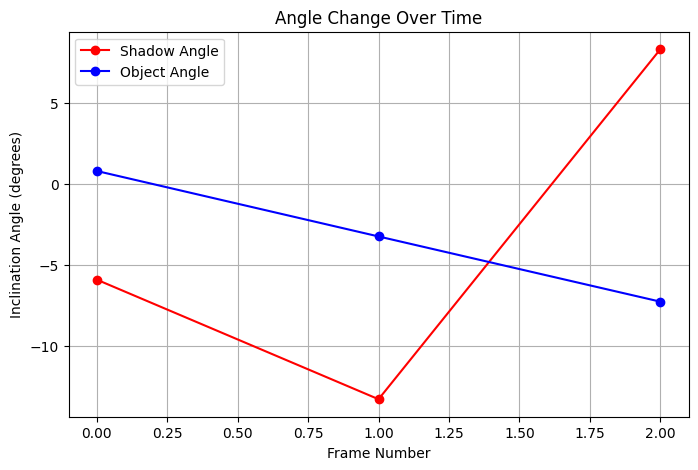

In [4]:
import cv2
import numpy as np
import re
import os
import matplotlib.pyplot as plt

# Hardcoded configuration
input_folder = 'C:/Users/User/Downloads/lframes/Shadow'  # Path to shadow-highlighted images
video_name = None  # Will be auto-detected

def detect_video_name_and_pattern(input_folder):
    """
    Detect the video name from existing frames in the folder.
    """
    files = [f for f in os.listdir(input_folder) if f.lower().endswith('_highlighted.png')]
    
    if not files:
        raise ValueError(f"No shadow-highlighted images found in {input_folder}")
    
    sample_file = files[0]
    
    match = re.match(r'(.+?)_frame_\d+_highlighted\.png', sample_file)
    
    if match:
        video_name = match.group(1)
        return video_name
    else:
        return "unknown"

def extract_shadow_mask(image):
    """Extracts the mask for red-highlighted shadows."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define red color range (shadows)
    lower1 = np.array([0, 120, 70])
    upper1 = np.array([10, 255, 255])
    lower2 = np.array([170, 120, 70])
    upper2 = np.array([180, 255, 255])

    # Create mask for red regions
    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)
    
    return mask1 + mask2  # Combine both masks

def extract_object_edges(image, shadow_mask):
    """Extracts object edges while ignoring the red shadow."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[shadow_mask > 0] = 0  # Mask out shadow regions

    # Apply GaussianBlur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    
    return edges

def calculate_inclination(edges):
    """Finds the inclination angle using Probabilistic Hough Transform."""
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)

    if lines is not None:
        angles = []
        for x1, y1, x2, y2 in lines[:, 0]:
            angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))  # Compute inclination
            angles.append(angle)
        
        # Filter out extreme angles
        angles = np.array(angles)
        filtered_angles = angles[(angles > -80) & (angles < 80)]  # Remove near-horizontal/vertical angles

        if len(filtered_angles) > 0:
            return np.mean(filtered_angles)  # Return robust average angle

    return None

def get_all_highlighted_images(input_folder):
    """Get all highlighted images from the folder, sorted by frame number."""
    highlighted_files = [f for f in os.listdir(input_folder) if f.lower().endswith('_highlighted.png')]
    
    if not highlighted_files:
        raise ValueError(f"No highlighted images found in {input_folder}")
    
    # Sort files by frame number
    def extract_frame_num(filename):
        match = re.search(r'_frame_(\d+)_highlighted\.png', filename)
        if match:
            return int(match.group(1))
        return 0
    
    highlighted_files.sort(key=extract_frame_num)
    image_paths = [os.path.join(input_folder, f) for f in highlighted_files]
    
    print(f"Found {len(image_paths)} highlighted frames to analyze")
    return image_paths

def process_images(image_paths):
    """Processes images, extracts inclination angles, and computes rate of change."""
    shadow_angles, object_angles = [], []

    for path in image_paths:
        image = cv2.imread(path)
        shadow_mask = extract_shadow_mask(image)

        shadow_angle = calculate_inclination(shadow_mask)
        object_edges = extract_object_edges(image, shadow_mask)
        object_angle = calculate_inclination(object_edges)
        
        if shadow_angle is not None:
            shadow_angles.append(shadow_angle)
        if object_angle is not None:
            object_angles.append(object_angle)

    if len(shadow_angles) < 3 or len(object_angles) < 3:
        print("Not enough valid frames to compute rate of change.")
        return

    # Compute rate of change using numpy.diff()
    shadow_rate = np.diff(shadow_angles)
    object_rate = np.diff(object_angles)

    # Compute separate thresholds
    shadow_threshold = 10
    object_threshold = 5

    if np.any(np.abs(shadow_rate) > shadow_threshold):
        shadow_class = "SHADOW"
    else:
        shadow_class = "OBJECT"

    if np.all(np.abs(object_rate) < object_threshold):
        object_class = "OBJECT"
    else:
        object_class = "SHADOW"


    # Additional Check: If both are SHADOW, compare absolute angles
    if shadow_class == "SHADOW" and object_class == "SHADOW":
        angle_diff = np.mean(np.abs(np.array(shadow_angles) - np.array(object_angles)))
        if angle_diff > 10:  # If object angles are much different from shadow
            object_class = "OBJECT"

    # Output the results
    print(f"Shadow Classification: {shadow_class}")
    print(f"Object Classification: {object_class}")
    print(f"Shadow Angle Changes: {shadow_angles}")
    print(f"Object Angle Changes: {object_angles}")
    print(f"Shadow Rate of Change: {shadow_rate}")
    print(f"Object Rate of Change: {object_rate}")
    print(f"Shadow Dynamic Threshold: {shadow_threshold}")
    print(f"Object Dynamic Threshold: {object_threshold}")
    if shadow_class == "SHADOW" and object_class == "SHADOW":
        print(f"Angle Difference Check: {angle_diff}")
    
     # Final Result
    print("\n--- FINAL RESULT ---")
    if shadow_class == "SHADOW" and object_class == "OBJECT":
        print("The red highlighted areas are SHADOWS")
    elif shadow_class == "OBJECT" and object_class == "OBJECT":
        print("The red highlighted areas are part of the OBJECT")
    else:
        print("Analysis inconclusive, more frames needed")
        
    return shadow_angles, object_angles

def visualize_shadow_object_angles(shadow_angles, object_angles):
    """Visualizes inclination angles over time for shadow and object regions."""
    if not shadow_angles or not object_angles:
        print("Insufficient data for visualization.")
        return

    frames = list(range(len(shadow_angles)))

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(shadow_angles)), shadow_angles, 'ro-', label="Shadow Angle")
    plt.plot(range(len(object_angles)), object_angles, 'bo-', label="Object Angle")
    plt.xlabel("Frame Number")
    plt.ylabel("Inclination Angle (degrees)")
    plt.legend()
    plt.title("Angle Change Over Time")
    plt.grid()
    plt.show()

# Add this in the main execution block AFTER process_images call
if __name__ == "__main__":
    try:
        video_name = detect_video_name_and_pattern(input_folder)
        image_paths = get_all_highlighted_images(input_folder)

        if len(image_paths) >= 2:
            shadow_angles, object_angles = process_images(image_paths)

            # Visualize
            visualize_shadow_object_angles(shadow_angles, object_angles)
        else:
            print("Not enough valid frames found for analysis.")

    except ValueError as e:
        print(f"Error: {e}")
